## 원본 데이터 확인하기

In [16]:
import os
import random
from itertools import combinations
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

### 원본 데이터 로드

In [17]:
data_path = os.path.join(os.getcwd(), '..', '..', 'Dataset') # os.getcwd() : 현재 파일 위치(working directory)
# os.path.join으로 현재 위치랑 부모폴더/부모폴더/Dataset의 경로를 지정
review_fname =os.path.join(data_path, 'PRADA_cocktail_reviews.json') # 마찬가지로 리뷰 데이터 경로를 os.path.join()으로 상대경로 지정
cocktail_fname = os.path.join(data_path, 'PRADA_cocktail_list.json')

reviews = pd.read_json(review_fname) # json 파일을 읽어드리는 panda
cocktails = pd.read_json(cocktail_fname)

# 중복(대댓글) 제거
reviews.drop_duplicates(subset=['Cocktail', 'User'], inplace=True) # Cocktail, User 칼럼 기준으로 중복된 데이터(대댓글) 제거

reviews # 데이터 보기
#cocktails.head()

,Cocktail,User,Date,Review
0,64,Trish,2018-05-03,Absolutely delicious! Everyone (even people wh...
1,64,Marnie Zorn,2017-04-08,"Pretty basic, I used club soda instead of 7up ..."
2,64,Angela,2017-01-02,I made this for new years it was a hit! No one...
3,64,Jillian,2011-07-12,Fabulous Punch! I made this for our annual Jul...
4,64,Katie,2010-07-11,Yummy! Only draw back is you can't really leav...
...,...,...,...,...
732,29,snakeeleven,2019-10-17,"ich habe den Drink mit Braunen Rum, Captain Mo..."
733,13,Katerchen,2021-03-22,Ein einfacher Cocktail mit nur zwei Zutaten. D...
734,13,Heinrich45,2019-12-24,Supereinfach zu machen und schmeckt immer wied...
735,13,DIELiz,2018-04-17,mal ein Cocktail für den nicht drei bis sieben...


### 유저 데이터 분포 확인하기

User
Katerchen           43
Silviatempelmayr    38
snakeeleven         36
DIELiz              32
Maarja              24
                    ..
Suzanne              3
Brandi               3
Lorraine             3
puersti              2
Billie-Blue          2
Name: Cocktail, Length: 112, dtype: int64


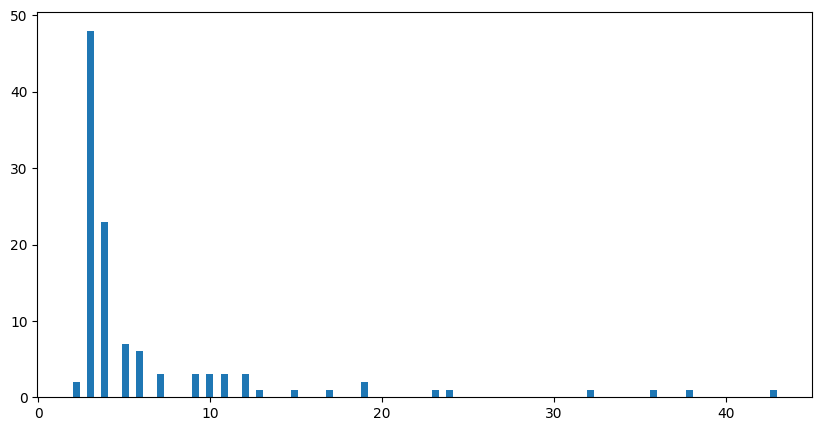

리뷰가 2개 이하인 유저 수:  2


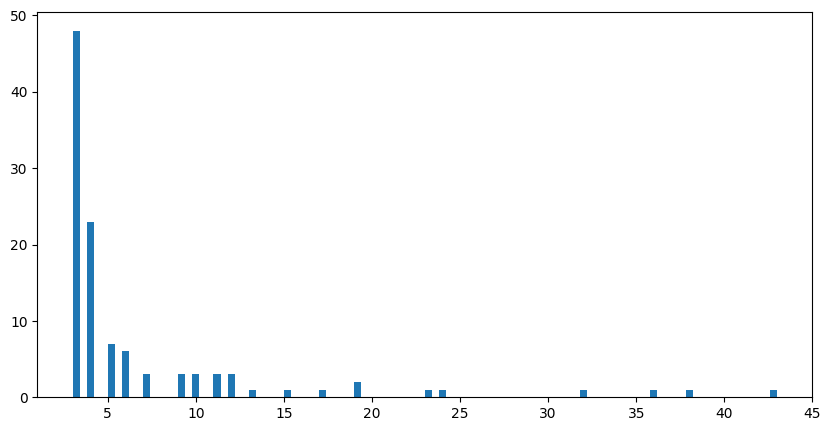

남은 유저 수 :  110


count    110.000000
mean       6.663636
std        7.366272
min        3.000000
25%        3.000000
50%        4.000000
75%        6.000000
max       43.000000
Name: Cocktail, dtype: float64

In [18]:
# 리뷰 수에 따른 데이터 분포 확인

## 유저별 리뷰 수 확인
count_review = reviews.groupby('User').count()['Cocktail'].sort_values(ascending=False)
print(count_review)

## 리뷰 수에 따른 유저 분포 그래프
plt.figure(figsize=(10, 5)) # 그래프 출력할 크기 지정
plt.hist(count_review, bins=100) # 히스토그램 호출
plt.show() # 출력

## count_review에서 리뷰가 3개 이하인 유저 수 확인
users_lt_2_reviews = count_review[count_review <= 2] # 리뷰가 2개 이하인 유저들의 데이터만 추출
print('리뷰가 2개 이하인 유저 수: ', len(users_lt_2_reviews))

## 리뷰가 1개인 유저 제거
reviews = reviews[~reviews['User'].isin(users_lt_2_reviews.index)] # user_lt_2_reviews의 index에 해당하지 않는 리뷰만 추출

## 리뷰 수에 따른 유저 분포 그래프
count_review = reviews.groupby('User').count()['Cocktail'].sort_values(ascending=False)
plt.figure(figsize=(10, 5))
plt.hist(count_review, bins=100)
plt.show()

print('남은 유저 수 : ', len(count_review))

count_review.describe()

In [19]:
## 각 count 별로 유저 수 확인
num_users_per_count = count_review.value_counts()

review_count_list = num_users_per_count.index.tolist()
num_users_list = num_users_per_count.tolist()

print("리뷰 수 \t 유저 수 \t 확률 \t 이론적 확률")
for review_count, num_user in zip(review_count_list, num_users_list):
    print(review_count, "\t", num_user, "\t", num_user/len(count_review), "\t", 1/(review_count)**3*12) # 리뷰 수에 따른 유저 확률 분포 출력




리뷰 수 	 유저 수 	 확률 	 이론적 확률
3 	 48 	 0.43636363636363634 	 0.4444444444444444
4 	 23 	 0.20909090909090908 	 0.1875
5 	 7 	 0.06363636363636363 	 0.096
6 	 6 	 0.05454545454545454 	 0.05555555555555555
12 	 3 	 0.02727272727272727 	 0.006944444444444444
7 	 3 	 0.02727272727272727 	 0.03498542274052478
9 	 3 	 0.02727272727272727 	 0.016460905349794237
10 	 3 	 0.02727272727272727 	 0.012
11 	 3 	 0.02727272727272727 	 0.009015777610818933
19 	 2 	 0.01818181818181818 	 0.001749526169995626
43 	 1 	 0.00909090909090909 	 0.00015093010678305055
38 	 1 	 0.00909090909090909 	 0.00021869077124945325
15 	 1 	 0.00909090909090909 	 0.0035555555555555557
17 	 1 	 0.00909090909090909 	 0.0024424994911459393
23 	 1 	 0.00909090909090909 	 0.0009862743486479823
24 	 1 	 0.00909090909090909 	 0.0008680555555555555
32 	 1 	 0.00909090909090909 	 0.0003662109375
36 	 1 	 0.00909090909090909 	 0.00025720164609053495
13 	 1 	 0.00909090909090909 	 0.005461993627674101


(array([35.,  0.,  0.,  0., 13.,  0.,  0.,  0.,  0., 15.,  0.,  0.,  0.,
         5.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
         0.,  5.,  0.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([ 5.  ,  5.22,  5.44,  5.66,  5.88,  6.1 ,  6.32,  6.54,  6.76,
         6.98,  7.2 ,  7.42,  7.64,  7.86,  8.08,  8.3 ,  8.52,  8.74,
         8.96,  9.18,  9.4 ,  9.62,  9.84, 10.06, 10.28, 10.5 , 10.72,
        10.94, 11.16, 11.38, 11.6 , 11.82, 12.04, 12.26, 12.48, 12.7 ,
        12.92, 13.14, 13.36, 13.58, 13.8 , 14.02, 14.24, 14.46, 14.68,
        14.9 , 15.12, 15.34, 15.56, 15.78, 16.  , 16.22, 16.44, 16.66,
        

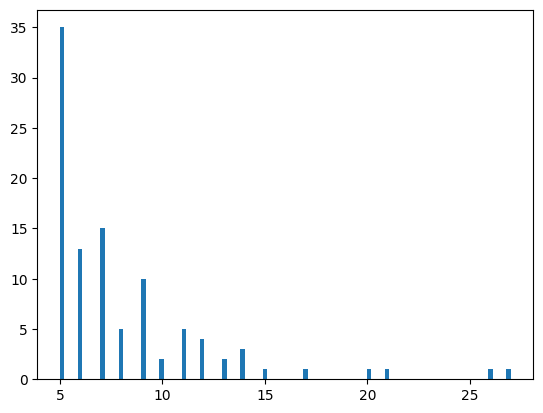

In [20]:
# 유저 별 리뷰 개수 생성하는 함수


def get_reiview_count():
    while(1):
        random_num = random.randint(5, 30) # 5~30 사이의 정수 난수 생성
        prob = get_power_prob(random_num) 
        if random.random() <= prob:
            return random_num

def get_power_prob(x):
    return 1/(x)**3*12

results = []
for i in range(100):
    results.append(get_reiview_count())

# 결과 시각화
plt.hist(results, bins=100)

### Rating 데이터 분포 확인하기

In [21]:
## 원본데이터는 rating이 없는 카럼이 존재하므로 Rating이 있는 데이터를 로드
ratings_fname = os.path.join(data_path, 'all_recipe_cocktail_reviews.json')

ratings = pd.DataFrame(list(pd.read_json(ratings_fname)['cocktail_reviews']))

ratings

,Cocktail,Name,User,Review,Rating,Date
0,1,Jamaican Rum Punch,Madaline Rose,this punch tastes good! i recommend it! there’...,5,11/25/2020
1,1,Jamaican Rum Punch,Wayne Wess,Pretty good. Added some pimento for more flavor,5,08/17/2020
2,1,Jamaican Rum Punch,JEM,Reminds me of a cousin to the Mai Tai. I also ...,5,05/28/2020
3,1,Jamaican Rum Punch,Jason Santiago,Added a pinch more of grenadine other than tha...,4,03/20/2020
4,1,Jamaican Rum Punch,Andrea Judd,Yumo! Made exactly except subbed regular Bacar...,5,06/01/2019
...,...,...,...,...,...,...
5690,59,Ultimate Frozen Strawberry Margarita,LYTHA,Ohhh yeah! I used frozen whole strawberries in...,4,05/02/2003
5691,59,Ultimate Frozen Strawberry Margarita,SOULFOODSARA,Just like the ones i've had in my favourite Me...,5,04/07/2003
5692,59,Ultimate Frozen Strawberry Margarita,ATOMICLUSH,"Very good strawberry margarita, however I cut ...",5,03/31/2003
5693,59,Ultimate Frozen Strawberry Margarita,Allrecipes Member,I've been searching for a good strawberry marg...,4,07/02/2001


In [22]:
# rating score에 따른 데이터 분포 확인
ratings.value_counts('Rating').apply(lambda x: x/len(ratings))

# 각 score 별 cocktail 수 확인
num_cocktails_per_score = ratings.value_counts('Rating')

score_list = num_cocktails_per_score.index.tolist()
num_cocktails_list = num_cocktails_per_score.tolist()

# 스코어별 확률 Dict
score_prob_dict = {score: 0 for score in range(1, 6)}

print("score \t 칵테일 \t 확률 \t")
for score, num_cocktail in zip(score_list, num_cocktails_list):
    prob = round(num_cocktail/len(ratings), 3)
    print(score, "\t", num_cocktail, "\t", prob)
    score_prob_dict[score] = prob

print(score_prob_dict)


score 	 칵테일 	 확률 	
5 	 4602 	 0.808
4 	 788 	 0.138
3 	 183 	 0.032
2 	 71 	 0.012
1 	 51 	 0.009
{1: 0.009, 2: 0.012, 3: 0.032, 4: 0.138, 5: 0.808}


In [23]:
def get_score():
    while(1):
        random_num = random.randint(1, 5)
        prob = score_prob_dict[random_num]
        if random.random() <= prob:
            return random_num
        
for i in range(10):
    print(get_score())

5
5
5
4
5
5
5
4
5
5


### 칵테일 분포 확인

In [24]:
kor_cocktail_fname = os.path.join(data_path, 'kor_cocktail_list.json')
kor_cocktails = pd.read_json(kor_cocktail_fname)
kor_cocktails_name_list = kor_cocktails['name'].tolist()

prada_cocktail_fname = os.path.join(data_path, 'PRADA_cocktail_list.json')
prada_cocktails = pd.read_json(prada_cocktail_fname)

prada_cocktails_name_list = prada_cocktails['Name'].tolist()

for k in kor_cocktails_name_list:
    if k not in prada_cocktails_name_list:
        print(k)

# PRADA 칵테일 중 한국어 칵테일에 없는 칵테일 제거
prada_cocktails = prada_cocktails[prada_cocktails['Name'].isin(kor_cocktails_name_list)]

In [26]:
# Association Rule 생성
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# transaction
transactions = reviews.groupby('User')['Cocktail'].apply(list).tolist()

# transaction encoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

# frequent itemset
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True)

# itemset size가 2 이상인 것만 추출
frequent_itemsets = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x)) >= 1]

frequent_itemsets

,support,itemsets
0,0.072727,(0)
1,0.090909,(8)
2,0.190909,(10)
3,0.118182,(11)
4,0.172727,(14)
...,...,...
755,0.054545,"(65, 19, 52, 22, 58, 92)"
756,0.054545,"(38, 71, 52, 22, 58, 92)"
757,0.054545,"(65, 38, 71, 52, 58, 92)"
758,0.054545,"(65, 38, 71, 14, 19, 22, 92)"


In [27]:
frequent_prob_dict = {}

for itemset, support in zip(frequent_itemsets['itemsets'], frequent_itemsets['support']):
    frequent_prob_dict[frozenset(itemset)] = support

frequent_prob_dict

{frozenset({0}): 0.07272727272727272,
 frozenset({8}): 0.09090909090909091,
 frozenset({10}): 0.19090909090909092,
 frozenset({11}): 0.11818181818181818,
 frozenset({14}): 0.17272727272727273,
 frozenset({15}): 0.09090909090909091,
 frozenset({16}): 0.07272727272727272,
 frozenset({19}): 0.18181818181818182,
 frozenset({22}): 0.16363636363636364,
 frozenset({23}): 0.07272727272727272,
 frozenset({26}): 0.19090909090909092,
 frozenset({27}): 0.07272727272727272,
 frozenset({28}): 0.43636363636363634,
 frozenset({32}): 0.06363636363636363,
 frozenset({37}): 0.08181818181818182,
 frozenset({38}): 0.16363636363636364,
 frozenset({39}): 0.08181818181818182,
 frozenset({43}): 0.05454545454545454,
 frozenset({44}): 0.16363636363636364,
 frozenset({47}): 0.08181818181818182,
 frozenset({50}): 0.06363636363636363,
 frozenset({51}): 0.06363636363636363,
 frozenset({52}): 0.21818181818181817,
 frozenset({55}): 0.38181818181818183,
 frozenset({57}): 0.18181818181818182,
 frozenset({58}): 0.4363636

In [28]:
# 확률 순으로 정렬
dict(sorted(frequent_prob_dict.items(), key=lambda x: x[1], reverse=True))

{frozenset({28}): 0.43636363636363634,
 frozenset({58}): 0.43636363636363634,
 frozenset({55}): 0.38181818181818183,
 frozenset({59}): 0.38181818181818183,
 frozenset({65}): 0.2545454545454545,
 frozenset({52}): 0.21818181818181817,
 frozenset({91}): 0.20909090909090908,
 frozenset({28, 59}): 0.20909090909090908,
 frozenset({28, 55}): 0.2,
 frozenset({28, 58}): 0.2,
 frozenset({55, 59}): 0.2,
 frozenset({10}): 0.19090909090909092,
 frozenset({26}): 0.19090909090909092,
 frozenset({19}): 0.18181818181818182,
 frozenset({57}): 0.18181818181818182,
 frozenset({14}): 0.17272727272727273,
 frozenset({71}): 0.17272727272727273,
 frozenset({55, 58}): 0.17272727272727273,
 frozenset({22}): 0.16363636363636364,
 frozenset({38}): 0.16363636363636364,
 frozenset({44}): 0.16363636363636364,
 frozenset({58, 59}): 0.16363636363636364,
 frozenset({92}): 0.15454545454545454,
 frozenset({58, 65}): 0.15454545454545454,
 frozenset({79}): 0.13636363636363635,
 frozenset({44, 65}): 0.13636363636363635,
 fr

## 데이터 생성

In [29]:
from itertools import combinations


In [34]:
cocktail_id_name_dict = {}

for i, row in prada_cocktails.iterrows():
    cocktail_id_name_dict[row['ID']] = row['Name']

cocktail_id_name_dict[3] = "Whiskey Highball"
    
num_users = 300

# 유저별 리뷰 개수 생성
review_count_list = []
for i in range(num_users):
    review_count_list.append(get_reiview_count())

# 유저별 리뷰 생성
user_reviews = []
is_selected = False
for idx, review_count in enumerate(review_count_list):
    print(idx, review_count)
    cocktail_selections = set()
    subsets = []
    while len(cocktail_selections) < review_count:
        # cocktail 선택
        new_cocktail_id = random.choice(list(cocktail_id_name_dict.keys()))

        # 이미 선택한 cocktail인 경우 continue
        if new_cocktail_id in cocktail_selections: continue

        # # 이전에 선택된 cocktail이 없다면
        # if len(cocktail_selections) == 0:
        #     if frozenset([new_cocktail_id]) in frequent_prob_dict:
        #         select_prob = frequent_prob_dict[frozenset([new_cocktail_id])]
        #         if random.random() <= select_prob:
        #             cocktail_selections.add(new_cocktail_id)
        #             print("성공")
        #             continue
        #         elif random.random() <= 0.5:
        #             cocktail_selections.add(new_cocktail_id)
        #             print("성공")
        #             continue

        #     if random.random() <= 0.5:
        #         cocktail_selections.add(new_cocktail_id)
        #     continue
        
        if len(cocktail_selections) == 0:
            if frozenset([new_cocktail_id]) in frequent_prob_dict:
            
                select_prob = frequent_prob_dict[frozenset([new_cocktail_id])]
                if random.random() <= select_prob:
                    cocktail_selections.add(new_cocktail_id)
                    #print("성공")

            elif random.random() <= 0.01:
                cocktail_selections.add(new_cocktail_id)


        else:
            if not is_selected:
            # candidate 생성
                subsets = []
                limit = 7 # 이상 넘어가면 메모리 터짐
                for i in range(1, len(cocktail_selections)+1):
                    if i > limit: break
                    for item in combinations(cocktail_selections, r=i):
                        subsets.append(item)

            # subsets에 있는 itemset이 frequent_itemsets에 있는지 확인
            is_selected = False
            for itemset in subsets:
                candidate = frozenset(itemset+(new_cocktail_id,))
                
                #print("candidate: ", candidate)
                if candidate in frequent_prob_dict:
                    select_prob = frequent_prob_dict[candidate]
                    if random.random() <= select_prob:
                        # 확률에 따라 선택되면 break
                        cocktail_selections.add(new_cocktail_id)
                        is_selected = True
                        break
            
            if is_selected: 
                #print("성공")
                continue

            cocktail_selections.add(new_cocktail_id) if random.random() <= 0.01 else None
    print(cocktail_selections)

    # 리뷰 생성
    for cocktail_id in cocktail_selections:
        user_reviews.append({
            'cocktailId': cocktail_id_name_dict[cocktail_id],
            'userId': idx,
            'rating': get_score(),
        })



0 6
{11, 44, 14, 52, 22, 58}
1 5
{64, 19, 58, 91, 28}
2 8
{64, 1, 71, 39, 11, 86, 91, 28}
3 8
{71, 72, 44, 79, 16, 22, 55, 91}
4 7
{1, 65, 72, 47, 80, 60, 63}
5 6
{71, 44, 19, 55, 23, 63}
6 24
{0, 8, 10, 11, 14, 16, 19, 22, 26, 38, 42, 44, 52, 55, 58, 63, 65, 71, 73, 79, 86, 88, 91, 92}
7 5
{65, 38, 71, 79, 91}
8 8
{10, 44, 79, 19, 52, 21, 58, 91}
9 6
{39, 52, 22, 58, 59, 28}
10 5
{65, 69, 38, 23, 27}
11 5
{3, 35, 13, 15, 83}
12 14
{0, 1, 65, 38, 11, 44, 14, 79, 16, 52, 55, 58, 91, 92}
13 17
{65, 37, 71, 40, 8, 10, 11, 44, 19, 84, 52, 86, 55, 57, 58, 59, 28}
14 5
{0, 44, 16, 59, 28}
15 5
{14, 58, 28, 29, 30}
16 29
{0, 8, 10, 11, 14, 16, 19, 22, 26, 27, 28, 37, 38, 44, 47, 52, 55, 57, 58, 59, 63, 65, 69, 71, 81, 84, 88, 91, 92}
17 8
{69, 38, 8, 9, 11, 44, 79, 22}
18 17
{65, 58, 38, 39, 40, 71, 91, 11, 44, 79, 16, 52, 22, 55, 26, 59, 92}
19 9
{1, 38, 71, 9, 55, 58, 59, 28, 63}
20 5
{1, 91, 12, 27, 30}
21 15
{64, 65, 26, 69, 38, 10, 92, 52, 21, 22, 55, 57, 58, 91, 28}
22 5
{59, 10, 55, 91

In [31]:
user_reviews

[{'cocktailId': 'Pina Colada', 'userId': 0, 'rating': 5},
 {'cocktailId': 'B-52', 'userId': 0, 'rating': 5},
 {'cocktailId': 'Vodka Apple', 'userId': 0, 'rating': 5},
 {'cocktailId': 'Cosmopolitan', 'userId': 0, 'rating': 5},
 {'cocktailId': 'Moscow Mule', 'userId': 0, 'rating': 4},
 {'cocktailId': 'Zombie', 'userId': 0, 'rating': 5},
 {'cocktailId': 'Pina Colada', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Grasshopper', 'userId': 1, 'rating': 5},
 {'cocktailId': 'B-52', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Long Island Iced Tea', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Vodka Martini', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Caipirinha', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Vodka Sour', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Mimosa', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Cosmopolitan', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Moscow Mule', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Zombie', 'userId': 1, 'rating': 5},
 {'cocktailId': 'Pina Colada', '

In [35]:
data_path

'c:\\Users\\gmk_0\\OneDrive\\바탕 화면\\myWork\\아주대학교\\4-1\\파란학기\\PRADA_AI\\Codes\\EDA\\..\\..\\Dataset'

In [37]:
import json

# json으로 저장
with open(os.path.join(data_path, 'synthetic_reviews.json'), 'w') as f:
    json.dump(user_reviews, f, indent=4, ensure_ascii=False)